In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
im = cv2.imread('./sudoku002.jpg')
im_h, im_w, _ = im.shape
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
 cv2.THRESH_BINARY,61,12)
binary = cv2.bitwise_not(thresh)

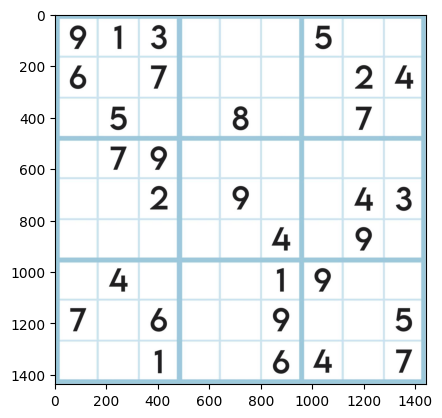

In [3]:
contours= cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = imutils.grab_contours(contours)
puzzle = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(puzzle)
puzzle_im = im[y:y+h, x:x+w]
puzzle_gray = gray[y:y+h, x:x+w]
plt.imshow(puzzle_im)

In [4]:
def get_corners(contour):
    top_left = contour[np.argmin([np.linalg.norm(x) for x in contour])][0]
    bottom_right = contour[np.argmax([np.linalg.norm(x) for x in contour])][0]
    points = [x[0] for x in contour]
    points = [(im_w - x, y) for x, y in points]
    top_right = contour[np.argmax([np.linalg.norm(x) for x in points])][0]
    bottom_left = contour[np.argmin([np.linalg.norm(x) for x in points])][0]
    return [top_left, bottom_left, top_right, bottom_right]

corners = get_corners(puzzle)
corners = np.array(corners)
corners[:, 0] -= x
corners[:, 1] -= y
print(corners)

[[   0    1]
 [1439    0]
 [   0 1436]
 [1441 1436]]


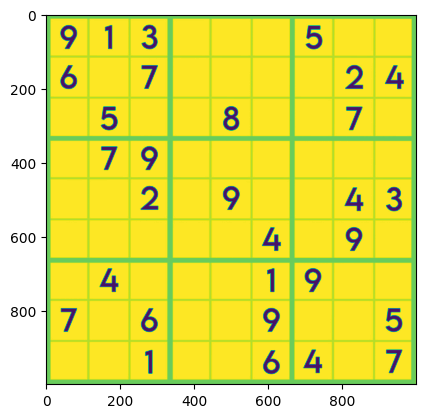

In [5]:
h, w = puzzle_im.shape[:2]    
src = np.float32(corners)
dst = np.float32([(w, 0),
                  (0, 0),
                  (w, h),
                  (0, h)])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(puzzle_gray, M, (w, h), flags=cv2.INTER_LINEAR)
warped = cv2.flip(warped, 1)
warped = cv2.resize(warped, (1000, 1000))

plt.imshow(warped)

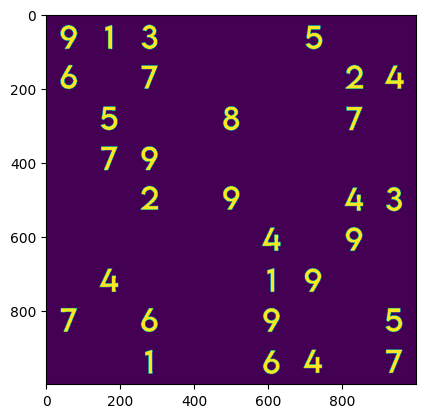

In [6]:
thresh = ~cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,61,12)
empty = np.zeros_like(thresh)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = [c for c in contours if (cv2.contourArea(c) > 100 and cv2.contourArea(c) < 10000)]
cv2.drawContours(empty, filtered_contours, -1, (255, 255, 255), -1)
plt.imshow(empty)

In [7]:
squares = np.zeros((9, 9), dtype=object)
h, w = warped.shape
for row in range(9):
    for col in range(9):
        squares[row, col]  = empty[(h * row)//9:(h * (row + 1))//9, (w * col)//9:(w * (col + 1))//9]

In [8]:
sums = np.array([np.sum(cv2.erode(square, np.ones((3, 3)))) for square in squares.ravel()])
sums_sorted = np.array(sorted(sums))
largest_gap = np.argmax(sums_sorted[1:] - sums_sorted[:-1])
full_square_thresh = sums_sorted[largest_gap]
sums = sums.reshape((9, 9))
number_mask = sums > full_square_thresh

In [9]:
def center(num):
    h, w = num.shape
    x_sums = np.sum(num, axis = 0)
    y_sums = np.sum(num, axis = 1)
    tot = np.sum(x_sums)
    x_avg, y_avg = 0, 0
    for idx, count in enumerate(x_sums):
        x_avg += idx * count
    for idx, count in enumerate(y_sums):
        y_avg += idx * count
    x_avg /= len(x_sums) * tot
    y_avg /= len(y_sums) * tot
    com = (int(x_avg * len(x_sums)), int(y_avg * len(y_sums)))
    shift = len(x_sums)//2 - com[0], len(y_sums)//2 - com[1]
    translation_matrix = np.float32([ [1,0, shift[0]], [0,1, shift[1]] ])
    cv2.warpAffine(num, translation_matrix, (h,w))
    return num

In [10]:
for row in range(9):
    for col in range(9):
        if number_mask[row, col]:
            squares[row, col] = center(squares[row, col])

#fig, axs = plt.subplots(9, 9) 
#for row in range(9):
#    for col in range(9):
#        axs[row, col].imshow(squares[row, col])
#        axs[row, col].axis('off')           

In [11]:
from model import Net
import torch 
model = Net()
model.load_state_dict(torch.load('./model_state.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4704, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
ground_truth = (9, 1, 3, 5, 6, 7, 2, 4, 5, 8, 7, 7, 9, 2, 9, 4, 3, 4, 9, 4, 1, 9, 7, 6, 9, 5, 1, 6, 4, 7)
len(ground_truth)

30

In [13]:
board = np.zeros((9, 9), int)
for row in range(9):
    for col in range(9):
        if number_mask[row, col]:
            num = squares[row, col]
            num = cv2.resize(num, (28, 28))
            num_t = torch.Tensor(np.round(num/256))
            num_t = num_t.unsqueeze(0)
            num_t = num_t.unsqueeze(0)

            outputs = model(num_t)
            _, predicted = torch.max(outputs.data, 1)
            board[row, col] = int(predicted)

board

array([[9, 1, 3, 0, 0, 0, 5, 0, 0],
       [6, 0, 7, 0, 0, 0, 0, 2, 4],
       [0, 5, 0, 0, 8, 0, 0, 7, 0],
       [0, 7, 9, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 9, 0, 0, 4, 3],
       [0, 0, 0, 0, 0, 4, 0, 9, 0],
       [0, 4, 0, 0, 0, 1, 9, 0, 0],
       [7, 0, 6, 0, 0, 9, 0, 0, 9],
       [0, 0, 1, 0, 0, 6, 4, 0, 7]])

In [14]:
from solve_sudoku import solve_sudoku

board, iters = solve_sudoku(board)
board, iters

('No Solution', 29)